In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import tqdm
import pathlib

In [5]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

In [6]:
DATA_DIR = pathlib.Path("./data/")

In [7]:
RS = 289475

### Версии:

- `numpy`: 1.16.3
- `pandas`: 0.24.2
- `sklearn`: 0.21.2

# Загрузка данных

In [83]:
train_target = pd.read_csv(DATA_DIR.joinpath("pet_target_train.csv"), index_col="date", parse_dates=["date"])
test_target = pd.read_csv(DATA_DIR.joinpath("pet_test_timestamps.csv"), index_col="date", parse_dates=["date"])
daily = pd.read_csv(DATA_DIR.joinpath("pet_daily.csv"), index_col="date", parse_dates=["date"])
weekly = pd.read_csv(DATA_DIR.joinpath("pet_weekly.csv"), index_col="date", parse_dates=["date"])

In [84]:
train_target.head()

,pet
date,
2004-06-01,961.25
2004-07-01,962.00
2004-08-01,1053.75
2004-09-01,1180.00
2004-10-01,1240.00


In [85]:
test_target.head()

""
date
2016-01-01
2016-02-01
2016-03-01
2016-04-01
2016-05-01


In [11]:
daily.head()

,brent_close,brent_open,brent_max,brent_min,USDCNY_close,USDCNY_open,USDCNY_max,USDCNY_min
date,,,,,,,,
2002-07-01,25.64,25.50,25.72,25.39,8.2770,8.2770,8.2770,8.2770
2002-07-02,25.75,25.61,25.97,25.60,8.2769,8.2769,8.2769,8.2769
2002-07-03,25.84,25.73,25.96,25.52,8.2768,8.2768,8.2768,8.2768
2002-07-04,25.55,25.88,25.94,25.50,8.2767,8.2767,8.2767,8.2767
2002-07-05,25.73,25.65,25.75,25.42,8.2766,8.2766,8.2766,8.2766


In [12]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4221 entries, 2002-07-01 to 2019-06-28
Data columns (total 8 columns):
brent_close     4221 non-null float64
brent_open      4221 non-null float64
brent_max       4221 non-null float64
brent_min       4221 non-null float64
USDCNY_close    4221 non-null float64
USDCNY_open     4221 non-null float64
USDCNY_max      4221 non-null float64
USDCNY_min      4221 non-null float64
dtypes: float64(8)
memory usage: 296.8 KB


In [13]:
weekly['paraxylene_CHN_USD'][~weekly['paraxylene_CHN_USD'].isnull()]

date
2005-01-07    955.0
2005-01-14    955.0
2005-01-21    975.0
2005-01-28    995.0
2005-02-04    965.0
              ...  
2019-07-19    853.0
2019-07-26    848.0
2019-08-02    819.0
2019-08-09    794.0
2019-08-16    790.0
Name: paraxylene_CHN_USD, Length: 744, dtype: float64

In [14]:
weekly.head()

,paraxylene_CHN_USD,paraxylene_RT_USD,paraxylene_SEA_USD,pta_NEA_USD,ethylene_glycol_EU_EUR,ethylene_glycol_CHN_USD
date,,,,,,
2004-04-30,NaN,669.0,735.0,NaN,622.5,860.0
2004-05-07,NaN,680.0,730.0,NaN,650.0,860.0
2004-05-14,NaN,664.0,720.0,NaN,650.0,857.5
2004-05-21,NaN,657.0,722.5,NaN,650.0,852.5
2004-05-28,NaN,667.5,735.0,NaN,650.0,857.5


In [15]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 799 entries, 2004-04-30 to 2019-08-16
Data columns (total 6 columns):
paraxylene_CHN_USD         744 non-null float64
paraxylene_RT_USD          782 non-null float64
paraxylene_SEA_USD         778 non-null float64
pta_NEA_USD                292 non-null float64
ethylene_glycol_EU_EUR     782 non-null float64
ethylene_glycol_CHN_USD    767 non-null float64
dtypes: float64(6)
memory usage: 43.7 KB


Text(0.5, 1, 'PET prices')

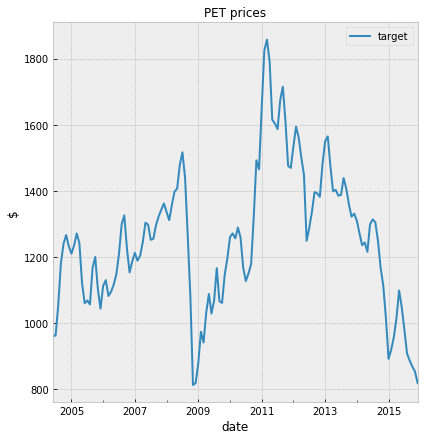

In [16]:
train_target["pet"].plot(ax=plt.gca(), label="target")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("PET prices", fontsize=12)

# Признаки

## Дневные данные

In [17]:
dfts = daily.resample("D").mean()
wfts = weekly.resample("D").ffill()
fts = dfts.join(wfts)

In [18]:
PERIODS = ["1D", "7D", "30D", "60D", "180D"]
AGGREGATES = ["mean", "median", "std", "max", "min"]

In [19]:
all_features = []

for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        if agg!="mean" and period=="1D":
            continue
        rolling_features = dfts.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features[rolling_features.index.day==9])

In [20]:
all_features = pd.concat(all_features, axis=1)

In [21]:
all_features["prediction_date"] = (all_features.index
                                   + pd.TimedeltaIndex(all_features.index.days_in_month-8,
                                                       unit="D"))

In [22]:
all_features.head()

,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,brent_close_7D_mean,brent_open_7D_mean,...,USDCNY_min_180D_max,brent_close_180D_min,brent_open_180D_min,brent_max_180D_min,brent_min_180D_min,USDCNY_close_180D_min,USDCNY_open_180D_min,USDCNY_max_180D_min,USDCNY_min_180D_min,prediction_date
date,,,,,,,,,,,,,,,,,,,,,
2002-07-09,25.17,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,25.474,25.6120,...,8.2770,25.08,25.10,25.20,24.75,8.2766,8.2766,8.2766,8.2766,2002-08-01
2002-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.120,25.1275,...,8.2770,24.89,24.89,25.08,24.65,8.2766,8.2766,8.2766,8.2766,2002-09-01
2002-09-09,28.49,28.61,28.65,28.05,8.2770,8.2770,8.2770,8.2770,27.622,27.6060,...,8.2772,24.89,24.89,25.08,24.65,8.2766,8.2766,8.2766,8.2766,2002-10-01
2002-10-09,28.13,28.09,28.40,27.87,8.2771,8.2771,8.2771,8.2771,28.166,28.4100,...,8.2773,24.89,24.89,25.08,24.65,8.2766,8.2766,8.2766,8.2766,2002-11-01
2002-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.720,24.1500,...,8.2773,23.48,23.66,23.92,23.25,8.2766,8.2766,8.2766,8.2766,2002-12-01


In [23]:
final_fts = all_features.ffill()

In [24]:
df = train_target.join(final_fts.set_index("prediction_date"), how="outer")["2004-06":]
df.index.name = "date"
df.head()

,pet,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,brent_close_7D_mean,...,USDCNY_max_180D_max,USDCNY_min_180D_max,brent_close_180D_min,brent_open_180D_min,brent_max_180D_min,brent_min_180D_min,USDCNY_close_180D_min,USDCNY_open_180D_min,USDCNY_max_180D_min,USDCNY_min_180D_min
date,,,,,,,,,,,,,,,,,,,,,
2004-06-01,961.25,32.23,32.95,33.14,32.15,8.2767,8.2767,8.2767,8.2767,36.5450,...,8.2774,8.2774,27.86,28.05,28.43,27.68,8.2767,8.2767,8.2767,8.2767
2004-07-01,962.00,35.29,34.75,35.44,34.43,8.2767,8.2767,8.2767,8.2767,35.6740,...,8.2774,8.2774,28.83,28.94,29.18,28.44,8.2767,8.2767,8.2767,8.2767
2004-08-01,1053.75,37.05,37.60,37.80,37.00,8.2769,8.2769,8.2769,8.2769,36.9820,...,8.2774,8.2774,28.83,29.00,29.18,28.44,8.2766,8.2766,8.2766,8.2766
2004-09-01,1180.00,37.05,37.60,37.80,37.00,8.2769,8.2769,8.2769,8.2769,40.5225,...,8.2774,8.2774,30.07,29.65,30.15,29.57,8.2766,8.2766,8.2766,8.2766
2004-10-01,1240.00,42.22,40.25,42.30,40.10,8.2768,8.2768,8.2768,8.2768,41.0440,...,8.2774,8.2774,30.21,30.69,30.92,29.95,8.2766,8.2766,8.2766,8.2766


In [25]:
df["month"] = df.index.month
FTS_COLS = df.columns[1:]
TARGET = "pet"

In [26]:
df.head()

,pet,brent_close_1D_mean,brent_open_1D_mean,brent_max_1D_mean,brent_min_1D_mean,USDCNY_close_1D_mean,USDCNY_open_1D_mean,USDCNY_max_1D_mean,USDCNY_min_1D_mean,brent_close_7D_mean,...,USDCNY_min_180D_max,brent_close_180D_min,brent_open_180D_min,brent_max_180D_min,brent_min_180D_min,USDCNY_close_180D_min,USDCNY_open_180D_min,USDCNY_max_180D_min,USDCNY_min_180D_min,month
date,,,,,,,,,,,,,,,,,,,,,
2004-06-01,961.25,32.23,32.95,33.14,32.15,8.2767,8.2767,8.2767,8.2767,36.5450,...,8.2774,27.86,28.05,28.43,27.68,8.2767,8.2767,8.2767,8.2767,6
2004-07-01,962.00,35.29,34.75,35.44,34.43,8.2767,8.2767,8.2767,8.2767,35.6740,...,8.2774,28.83,28.94,29.18,28.44,8.2767,8.2767,8.2767,8.2767,7
2004-08-01,1053.75,37.05,37.60,37.80,37.00,8.2769,8.2769,8.2769,8.2769,36.9820,...,8.2774,28.83,29.00,29.18,28.44,8.2766,8.2766,8.2766,8.2766,8
2004-09-01,1180.00,37.05,37.60,37.80,37.00,8.2769,8.2769,8.2769,8.2769,40.5225,...,8.2774,30.07,29.65,30.15,29.57,8.2766,8.2766,8.2766,8.2766,9
2004-10-01,1240.00,42.22,40.25,42.30,40.10,8.2768,8.2768,8.2768,8.2768,41.0440,...,8.2774,30.21,30.69,30.92,29.95,8.2766,8.2766,8.2766,8.2766,10


# Модели

In [27]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Train/CV

In [28]:
tr = df[:"2013"].copy()
cv = df["2014":"2015"].copy()
ts = df["2016":].copy()

Text(0.5, 1, 'pet prices')

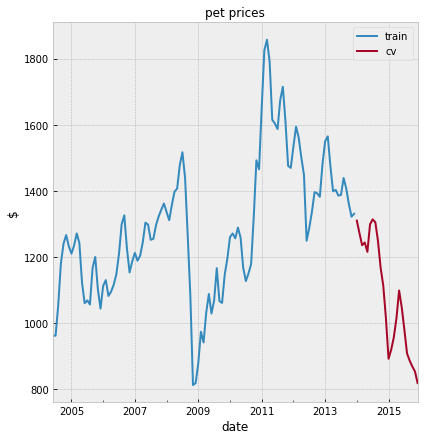

In [29]:
tr["pet"].plot(ax=plt.gca(), label="train")
cv["pet"].plot(ax=plt.gca(), label="cv")
plt.legend(loc=0)
plt.ylabel("$")
plt.tight_layout()
plt.title("pet prices", fontsize=12)

## Тривиальные бенчмарки

## Фильтруем признаки

In [30]:
print(f"Naive benchmark (last known value): {100 * mape(cv[TARGET], tr.iloc[-1][TARGET]):0.1f}")
print(f"Naive benchmark (CV period median): {100 * mape(cv[TARGET], tr[TARGET].median()):0.1f}")

Naive benchmark (last known value): 26.0
Naive benchmark (CV period median): 20.9


In [31]:
naive_baseline = test_target.copy()
naive_baseline["pet"] = df[TARGET].median()
naive_baseline.to_csv(DATA_DIR.joinpath("pet_naive_baseline.csv"))

In [30]:
corrs = tr.corr().loc[TARGET, FTS_COLS[:-1]]

In [31]:
corrs.abs().sort_values(ascending=False).head(25)

brent_min_7D_min         0.747031
brent_close_7D_min       0.745576
brent_open_7D_min        0.742534
brent_max_7D_min         0.742294
brent_min_7D_mean        0.742167
brent_close_7D_median    0.741957
brent_close_7D_mean      0.741379
brent_min_7D_median      0.740387
brent_open_7D_median     0.739480
brent_open_7D_mean       0.736746
brent_max_7D_mean        0.735928
brent_min_7D_max         0.735559
brent_max_7D_median      0.734631
brent_close_7D_max       0.730987
brent_max_7D_max         0.728108
brent_open_7D_max        0.727983
brent_min_30D_min        0.726494
brent_close_30D_min      0.726260
brent_open_30D_min       0.722137
brent_max_30D_min        0.721894
brent_close_1D_mean      0.720907
brent_min_1D_mean        0.718770
brent_max_1D_mean        0.714021
brent_min_60D_min        0.713307
brent_close_60D_min      0.712315
Name: pet, dtype: float64

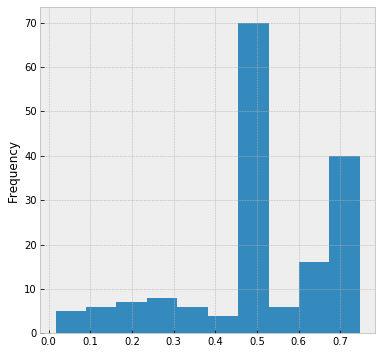

In [32]:
corrs.abs().plot(kind="hist")

In [33]:
FCOLS = corrs[corrs.abs()>=0.2].index

In [34]:
FCOLS

Index(['brent_close_1D_mean', 'brent_open_1D_mean', 'brent_max_1D_mean',
       'brent_min_1D_mean', 'USDCNY_close_1D_mean', 'USDCNY_open_1D_mean',
       'USDCNY_max_1D_mean', 'USDCNY_min_1D_mean', 'brent_close_7D_mean',
       'brent_open_7D_mean',
       ...
       'USDCNY_max_180D_max', 'USDCNY_min_180D_max', 'brent_close_180D_min',
       'brent_open_180D_min', 'brent_max_180D_min', 'brent_min_180D_min',
       'USDCNY_close_180D_min', 'USDCNY_open_180D_min', 'USDCNY_max_180D_min',
       'USDCNY_min_180D_min'],
      dtype='object', length=156)

## Линейная модель

Подбираем параметры:

In [35]:
params = ParameterGrid({"alpha":[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], "l1_ratio":[0.1, 0.25, 0.5, 0.75, 1.]})
errors = []

for param in params:
    lmodel = ElasticNet(alpha=param["alpha"], l1_ratio=param["l1_ratio"], random_state=RS)
    lmodel.fit(tr[FCOLS], tr[TARGET])

    ltr_preds = pd.Series(lmodel.predict(tr[FCOLS]), index=tr.index)
    lcv_preds = pd.Series(lmodel.predict(cv[FCOLS]), index=cv.index)

    cv_mape = mape(cv[TARGET], lcv_preds)
    errors.append({"mape":cv_mape, "alpha":param["alpha"], "l1_ratio":param["l1_ratio"]})

errors = pd.DataFrame.from_records(errors)

c:\users\shepe\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 559985.8227331932, tolerance: 483.02647943236707
  positive)
c:\users\shepe\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 558262.8195655317, tolerance: 483.02647943236707
  positive)
c:\users\shepe\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 553998.5534193565, tolerance: 483.02647943236707
  positive)
c:\users\shepe\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546276.16

In [36]:
errors.iloc[errors["mape"].idxmin()]

mape        0.173805
alpha       1.000000
l1_ratio    0.100000
Name: 15, dtype: float64

In [37]:
model = ElasticNet(alpha=1, l1_ratio=0.1, random_state=RS)
model.fit(tr[FCOLS].values, tr[TARGET].values)

c:\users\shepe\python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691249.0528850446, tolerance: 483.02647943236707
  positive)


ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=289475, selection='cyclic', tol=0.0001,
           warm_start=False)

TR performance: 6.3%
CV performance: 17.4%


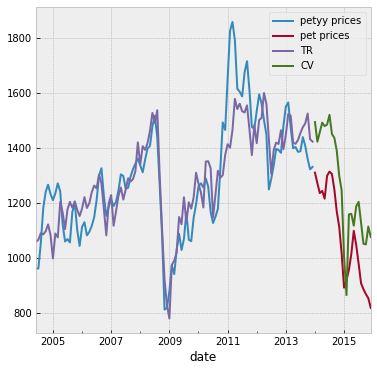

In [38]:
tr_preds = pd.Series(model.predict(tr[FCOLS]), index=tr.index)
cv_preds = pd.Series(model.predict(cv[FCOLS]), index=cv.index)

print(f"TR performance: {100 * mape(tr[TARGET], tr_preds):0.1f}%")
print(f"CV performance: {100 * mape(cv[TARGET], cv_preds):0.1f}%")

plt.figure()
tr[TARGET].plot(ax=plt.gca(), label="petyy prices");
cv[TARGET].plot(ax=plt.gca(), label="pet prices");
tr_preds.plot(ax=plt.gca(), label="TR");
cv_preds.plot(ax=plt.gca(), label="CV");
plt.legend(loc=0);

Считаем предсказания для тестового набора:

### Using technical analysis

In [39]:
from scipy.signal import find_peaks
import scipy.signal

In [64]:
def analysis(cost_data, n_mean, distance, window_length):
    tr_series = pd.Series(cost_data.values.reshape(-1), index=cost_data.index)

    plt.figure(figsize=(10, 10))

    peaks, _ = find_peaks(cost_data.values.reshape(-1), distance = distance)
    valleys, _ = find_peaks(cost_data.values.reshape(-1)*(-1), distance = distance)

    plt.plot(cost_data.index[peaks], cost_data.values[peaks], color = 'red')
    plt.plot(cost_data.index[valleys], cost_data.values[valleys], color = 'green')
    tr_series.rolling(n_mean).mean().plot(ax = plt.gca(), label=f'moving average (n = {n_mean})', color='blue')
    tr_series.plot(ax = plt.gca(), label = 'original', color='black')
    

    delta = cost_data.diff()[1:]
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up1 = up.ewm(span=window_length).mean()
    roll_down1 = down.abs().ewm(span=window_length).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(window_length).mean()
    roll_down2 = down.abs().rolling(window_length).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    # Compare graphically
    plt.figure(figsize=(10, 4))
    plt.plot(cost_data.index, [80]*len(cost_data.index))
    plt.plot(cost_data.index, [20]*len(cost_data.index))
    RSI1.plot(ax=plt.gca())
    RSI2.plot(ax=plt.gca())
    plt.legend(['high', 'low', 'RSI via EWMA', 'RSI via SMA'])
    plt.show()

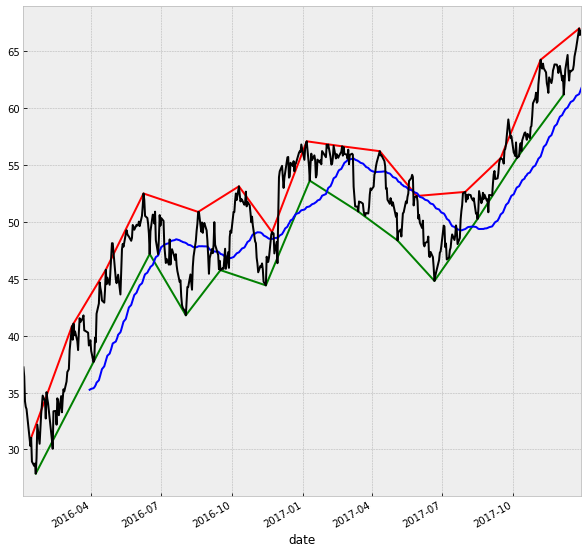

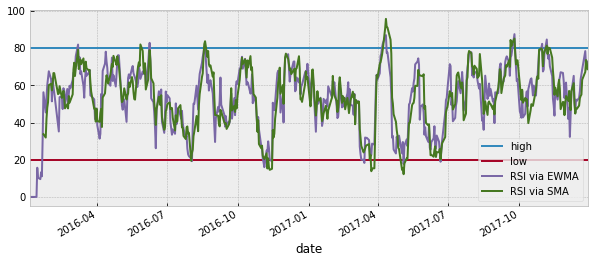

In [65]:
analysis(daily['brent_close']['2016':'2017'], 60, 30, 14)

In [86]:
test_target['pet'] = 0

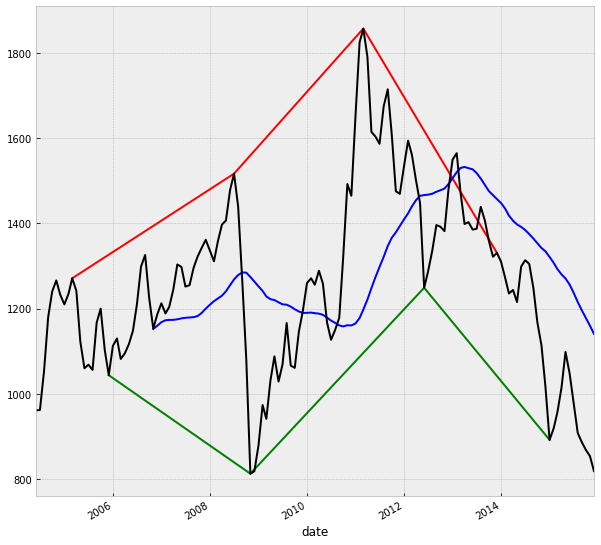

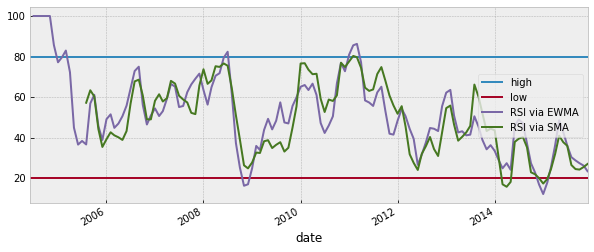

In [88]:
analysis(train_target, 30, 30, 14)

In [89]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [296]:
x = (train_target.join(daily).join(weekly)).ffill(axis=0)[::-1].ffill(axis=0)[::-1]
y = train_target

In [381]:
n_steps_in = 30
n_classes = x.shape[1]
n_out = len(test_target) #4

inp = layers.Input((n_steps_in, n_classes), dtype='float32')
r = layers.LSTM(50, return_sequences=True, dropout=0.1)(inp)
r1 = layers.BatchNormalization()(r)
t = layers.LSTM(50, return_sequences=False)(r1)
p = layers.Dense(64)(t)
p = layers.Dense(32)(p)
p = layers.Dense(n_out)(p)

model = tf.keras.Model(inp, p)
model.compile(loss=tf.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [369]:
def batch(data_x, data_y, size):
    assert size[1] <= len(data_x) - n_out
    assert type(size) == tuple
    assert len(size) == 2
    
    indexes = np.array([(lambda start_id:
           np.arange(start_id, start_id + size[1] + n_out))(np.random.randint(0, len(data_x)-size[1]-n_out)) for i in range(size[0])])

    indexes[:, :size[1]]
    return data_x[indexes[:, :size[1]]], data_y[indexes[:, size[1]:]].reshape((size[0], n_out))

In [347]:
# к признакам добавить предыдущую цену
# вычленить индекс для новой цены (аккуратно - индекс должен существовать)
# правильно сгенерить предсказания

In [382]:
len_epochs = 50
batch_size = 32

for epoch in range(len_epochs):
    
    x_batch, y_batch = batch(
        x.values.astype('float32'),
        y.values.astype('float32'), (batch_size, n_steps_in)
    )
    
    model.fit(x_batch, y_batch, validation_split=0.1, epochs=10)    

Train on 28 samples, validate on 4 samples
Epoch 1/10
28/28 [==============================] - 5s 185ms/sample - loss: 1920759.8750 - accuracy: 0.0357 - val_loss: 1740924.2500 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 2ms/sample - loss: 1920683.3750 - accuracy: 0.0357 - val_loss: 1740763.7500 - val_accuracy: 0.0000e+00
Epoch 3/10
28/28 [==============================] - 0s 2ms/sample - loss: 1920580.8750 - accuracy: 0.0357 - val_loss: 1740648.1250 - val_accuracy: 0.0000e+00
Epoch 4/10
28/28 [==============================] - 0s 1ms/sample - loss: 1920475.8750 - accuracy: 0.0000e+00 - val_loss: 1740652.3750 - val_accuracy: 0.0000e+00
Epoch 5/10
28/28 [==============================] - 0s 1ms/sample - loss: 1920339.1250 - accuracy: 0.0000e+00 - val_loss: 1740395.7500 - val_accuracy: 0.0000e+00
Epoch 6/10
28/28 [==============================] - 0s 1ms/sample - loss: 1920052.8750 - accuracy: 0.0000e+00 - val_loss: 1739850.8750 - val_accuracy: 0.0000

Epoch 6/10
28/28 [==============================] - 0s 1ms/sample - loss: 1781016.3750 - accuracy: 0.0000e+00 - val_loss: 1631328.2500 - val_accuracy: 0.0000e+00
Epoch 7/10
28/28 [==============================] - 0s 1ms/sample - loss: 1772990.8750 - accuracy: 0.0000e+00 - val_loss: 1623330.7500 - val_accuracy: 0.0000e+00
Epoch 8/10
28/28 [==============================] - 0s 1ms/sample - loss: 1764807.1250 - accuracy: 0.0000e+00 - val_loss: 1615332.2500 - val_accuracy: 0.0000e+00
Epoch 9/10
28/28 [==============================] - 0s 1ms/sample - loss: 1755697.7500 - accuracy: 0.0000e+00 - val_loss: 1607118.7500 - val_accuracy: 0.0000e+00
Epoch 10/10
28/28 [==============================] - 0s 1ms/sample - loss: 1746595.2500 - accuracy: 0.0000e+00 - val_loss: 1598636.7500 - val_accuracy: 0.0000e+00
Train on 28 samples, validate on 4 samples
Epoch 1/10
28/28 [==============================] - 0s 1ms/sample - loss: 1627490.0000 - accuracy: 0.0357 - val_loss: 1571646.0000 - val_accuracy:

Epoch 7/10
28/28 [==============================] - 0s 1ms/sample - loss: 1061255.8750 - accuracy: 0.0357 - val_loss: 1169966.3750 - val_accuracy: 0.0000e+00
Epoch 8/10
28/28 [==============================] - 0s 1ms/sample - loss: 1046243.9375 - accuracy: 0.0357 - val_loss: 1154307.3750 - val_accuracy: 0.0000e+00
Epoch 9/10
28/28 [==============================] - 0s 1ms/sample - loss: 1032232.0625 - accuracy: 0.0357 - val_loss: 1138475.1250 - val_accuracy: 0.0000e+00
Epoch 10/10
28/28 [==============================] - 0s 1ms/sample - loss: 1016971.0625 - accuracy: 0.0357 - val_loss: 1122700.8750 - val_accuracy: 0.0000e+00
Train on 28 samples, validate on 4 samples
Epoch 1/10
28/28 [==============================] - 0s 1ms/sample - loss: 1020731.9375 - accuracy: 0.0000e+00 - val_loss: 1064758.7500 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 1ms/sample - loss: 1005977.8750 - accuracy: 0.0000e+00 - val_loss: 1049006.5000 - val_accuracy: 0.0000e+00


28/28 [==============================] - 0s 1ms/sample - loss: 337406.1562 - accuracy: 0.0000e+00 - val_loss: 737314.4375 - val_accuracy: 0.2500
Epoch 8/10
28/28 [==============================] - 0s 1ms/sample - loss: 326201.9375 - accuracy: 0.0000e+00 - val_loss: 650472.8750 - val_accuracy: 0.2500
Epoch 9/10
28/28 [==============================] - 0s 1ms/sample - loss: 315051.0938 - accuracy: 0.0000e+00 - val_loss: 676277.3750 - val_accuracy: 0.2500
Epoch 10/10
28/28 [==============================] - 0s 1ms/sample - loss: 304047.8438 - accuracy: 0.0000e+00 - val_loss: 626819.8125 - val_accuracy: 0.2500
Train on 28 samples, validate on 4 samples
Epoch 1/10
28/28 [==============================] - 0s 1ms/sample - loss: 299987.2812 - accuracy: 0.0357 - val_loss: 604403.6875 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 1ms/sample - loss: 289317.3125 - accuracy: 0.0357 - val_loss: 596353.6875 - val_accuracy: 0.0000e+00
Epoch 3/10
28/28 [=============

28/28 [==============================] - 0s 1ms/sample - loss: 62967.5664 - accuracy: 0.0357 - val_loss: 51993.2266 - val_accuracy: 0.0000e+00
Epoch 9/10
28/28 [==============================] - 0s 1ms/sample - loss: 62154.1328 - accuracy: 0.0357 - val_loss: 51801.5234 - val_accuracy: 0.0000e+00
Epoch 10/10
28/28 [==============================] - 0s 1ms/sample - loss: 61401.4180 - accuracy: 0.0357 - val_loss: 51638.4609 - val_accuracy: 0.0000e+00
Train on 28 samples, validate on 4 samples
Epoch 1/10
28/28 [==============================] - 0s 2ms/sample - loss: 57874.5117 - accuracy: 0.0357 - val_loss: 48901.9336 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 1ms/sample - loss: 57293.9414 - accuracy: 0.0000e+00 - val_loss: 48589.1523 - val_accuracy: 0.0000e+00
Epoch 3/10
28/28 [==============================] - 0s 1ms/sample - loss: 56752.0820 - accuracy: 0.0000e+00 - val_loss: 48305.5586 - val_accuracy: 0.0000e+00
Epoch 4/10
28/28 [=================

Epoch 10/10
28/28 [==============================] - 0s 1ms/sample - loss: 47945.2891 - accuracy: 0.0357 - val_loss: 54489.4805 - val_accuracy: 0.2500
Train on 28 samples, validate on 4 samples
Epoch 1/10
28/28 [==============================] - 0s 1ms/sample - loss: 50088.2617 - accuracy: 0.0357 - val_loss: 47239.9375 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 1ms/sample - loss: 48825.2812 - accuracy: 0.0357 - val_loss: 47014.7227 - val_accuracy: 0.0000e+00
Epoch 3/10
28/28 [==============================] - 0s 1ms/sample - loss: 47794.7500 - accuracy: 0.0357 - val_loss: 46493.3672 - val_accuracy: 0.0000e+00
Epoch 4/10
28/28 [==============================] - 0s 1ms/sample - loss: 47613.1211 - accuracy: 0.0357 - val_loss: 45971.9375 - val_accuracy: 0.0000e+00
Epoch 5/10
28/28 [==============================] - 0s 1ms/sample - loss: 46991.5312 - accuracy: 0.0357 - val_loss: 46229.8750 - val_accuracy: 0.0000e+00
Epoch 6/10
28/28 [==================

28/28 [==============================] - 0s 1ms/sample - loss: 49469.6602 - accuracy: 0.0357 - val_loss: 463697.3438 - val_accuracy: 0.0000e+00
Epoch 2/10
28/28 [==============================] - 0s 1ms/sample - loss: 48282.8125 - accuracy: 0.0000e+00 - val_loss: 370267.8438 - val_accuracy: 0.0000e+00
Epoch 3/10
28/28 [==============================] - 0s 1ms/sample - loss: 48458.4023 - accuracy: 0.0000e+00 - val_loss: 377089.6562 - val_accuracy: 0.0000e+00
Epoch 4/10
28/28 [==============================] - 0s 1ms/sample - loss: 47293.0273 - accuracy: 0.0357 - val_loss: 373053.1250 - val_accuracy: 0.0000e+00
Epoch 5/10
28/28 [==============================] - 0s 1ms/sample - loss: 47809.6250 - accuracy: 0.0357 - val_loss: 464077.9062 - val_accuracy: 0.0000e+00
Epoch 6/10
28/28 [==============================] - 0s 1ms/sample - loss: 47148.8242 - accuracy: 0.0357 - val_loss: 465725.7500 - val_accuracy: 0.0000e+00
Epoch 7/10
28/28 [==============================] - 0s 1ms/sample - loss:

Epoch 3/10
28/28 [==============================] - 0s 1ms/sample - loss: 38053.2812 - accuracy: 0.0000e+00 - val_loss: 301370.3125 - val_accuracy: 0.0000e+00
Epoch 4/10
28/28 [==============================] - 0s 1ms/sample - loss: 37861.7305 - accuracy: 0.0000e+00 - val_loss: 234636.0312 - val_accuracy: 0.0000e+00
Epoch 5/10
28/28 [==============================] - 0s 1ms/sample - loss: 37680.6758 - accuracy: 0.0000e+00 - val_loss: 335728.8750 - val_accuracy: 0.0000e+00
Epoch 6/10
28/28 [==============================] - 0s 1ms/sample - loss: 37929.3984 - accuracy: 0.0000e+00 - val_loss: 28038.2773 - val_accuracy: 0.0000e+00
Epoch 7/10
28/28 [==============================] - 0s 1ms/sample - loss: 37546.6680 - accuracy: 0.0714 - val_loss: 25950.9219 - val_accuracy: 0.0000e+00
Epoch 8/10
28/28 [==============================] - 0s 1ms/sample - loss: 37322.3828 - accuracy: 0.0714 - val_loss: 25636.3809 - val_accuracy: 0.0000e+00
Epoch 9/10
28/28 [==============================] - 0s 1m

AttributeError: 'ProgbarLogger' object has no attribute 'log_values'

In [364]:
# UNFINISHED
x_start = train_target[-n_steps_in:].join(daily).join(weekly).ffill(axis=0)[::-1].ffill(axis=0)[::-1]
out_start = model(x_start.values.reshape(1, n_steps_in, len(x_start.columns))).numpy()

for i in range(len(test_target)):
    added = pd.concat(train_target[-n_steps_in:], out_start)
    
    (train_target.join(daily).join(weekly)).ffill(axis=0)[::-1].ffill(axis=0)[::-1]
    x = n_steps_in

In [387]:
a = test_target.copy()
a['pet'] = model(x.values[-n_steps_in:].reshape((1, n_steps_in, n_classes))).numpy()[0]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



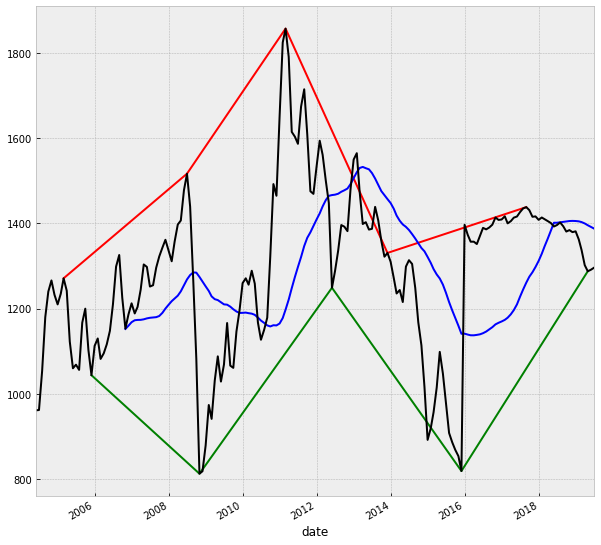

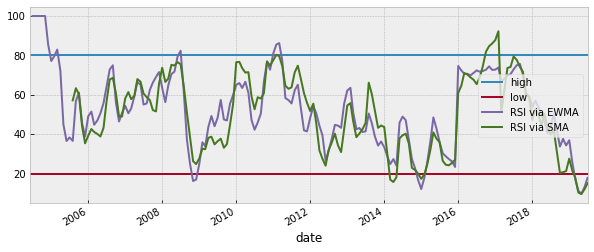

In [388]:
analysis(pd.concat([train_target, a]), 30, 30, 14)

In [390]:
a.to_csv((".\data\pet_tec.csv"))